In [ ]:
from IPython.display import Audio
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import stft, istft
import scipy.io.wavfile
import os.path
from os import path
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

music_dir = "/content/gdrive/MyDrive/APS360 Group Project/APS360 Datasets/Celestial Shore - Die For Us"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Get Mixture Audio and Perform STFT 

### Get mixture audio

In [ ]:
# get mixture audio
sample_rate_mix, data_mix = scipy.io.wavfile.read(os.path.join(music_dir,"mixture.wav"))
print(data_mix.shape)
# stft can only take (channel,samples)
data_mix=data_mix.T
print(data_mix.shape)

# play
Audio(data_mix, rate=sample_rate_mix)

(300032, 2)
(2, 300032)


### Perform stft on Mixture

Below is an instruction of how to use scipy.signal.stft

For details: 

https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/ 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html


num_segments:   2345.0
num_frequencies:   129.0
num_channels:   2


f shape:   (129,)
t shape:   (2345,)
Zxx shape:   (2, 129, 2345)


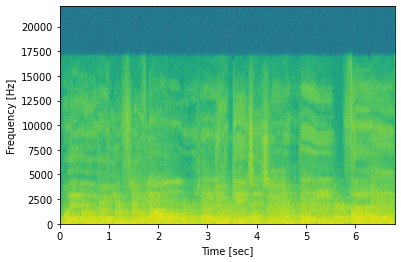

In [ ]:
##################
#  STFT

nperseg=256           # length of a segment
noverlap=nperseg//2   # overlap btwn segments, default to nperseg//2

# f: list of all the frequencies to check
# t: starting time of each segments
# Zxx: spectrogram
f_mix,t_mix,Zxx_mix = scipy.signal.stft(x=data_mix, 
              fs = sample_rate_mix,       
              nperseg=nperseg,
              noverlap=noverlap)


##################
#  VERIFICATIONS

# num_segments
stride = nperseg - noverlap
print("num_segments:  ",np.ceil((data_mix.shape[1]+1)/stride))
# num_frequencies
print("num_frequencies:  ",nperseg/2+1)
# num_channels
print("num_channels:  ",data_mix.shape[0])
print("\n")

# list of all the frequencies to check
print("f shape:  ", f_mix.shape)    
# starting time of each segments
print("t shape:  ", t_mix.shape)
# spectrogram
print("Zxx shape:  ", Zxx_mix.shape)


##################
# PLOT

plt.pcolormesh(t_mix, f_mix, np.log(np.abs(Zxx_mix[0])), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Get Vocals Audio and Perform STFT 

### Get vocals audio

In [ ]:
##################
# get vocals audio
sample_rate_vol, data_vol = scipy.io.wavfile.read(os.path.join(music_dir,"vocals.wav"))
data_vol=data_vol.T

# play
Audio(data_vol, rate=sample_rate_vol)

### Perform stft on vocals



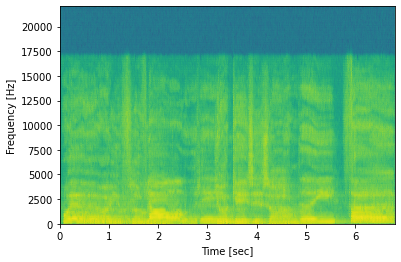

In [ ]:
##################
# get vocals spectrogram
f_vol,t_vol,Zxx_vol = scipy.signal.stft(x=data_vol, 
              fs = sample_rate_vol,       
              nperseg=nperseg,
              noverlap=noverlap)
# plot 
plt.pcolormesh(t_vol, f_vol, np.log(np.abs(Zxx_vol[0])), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Get Accompaniment Audio and Perform STFT

### Get accompaniment audio

In [ ]:
##################
# get accompaniment audio
sample_rate_acc, data_acc = scipy.io.wavfile.read(os.path.join(music_dir,"accomp.wav"))
data_acc=data_acc.T

# play
Audio(data_acc, rate=sample_rate_acc)

### Perform stft on accomp


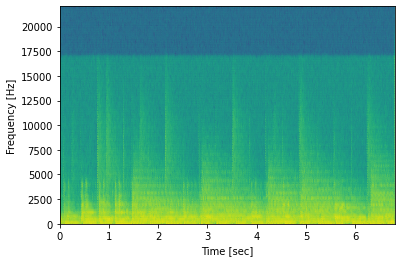

In [ ]:
##################
# get vocals spectrogram
f_acc,t_acc,Zxx_acc = scipy.signal.stft(x=data_acc, 
              fs = sample_rate_acc,       
              nperseg=nperseg,
              noverlap=noverlap)
# plot 
plt.pcolormesh(t_acc, f_acc, np.log(np.abs(Zxx_acc[0])), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Ratio Mask Filtering (Oracle)

Spectrograms are images ! We cannot reconstruct easily audio for them, because we miss the phase information.

However, if we have the spectrograms of all the sources, we may use the mixture and its phase to get good estimates for the sources.
That's what called `oracle filtering` in the jargon. 

Let's separate the vocals this way.

In short, it means keeping only the parts of the mix that are vocals. This is done by applying a *mask* to the mix, which is either 1 (vocals) or 0 (non vocals.). This mask is given by:

$Mask_{vocals}=\frac{S_{vocals}}{S_{vocals}+S_{accompaniment}}$

and is called a *ratio mask*

### Compute the ratio mask

In [ ]:
# get both abs(Zxx) for vocals and accomp
S_vocals = Zxx_vol # abs() makes bad estimation tho
S_accomp = Zxx_acc

# small epsilon to avoid dividing by zero
eps = np.finfo(float).eps


# compute model as the sum of spectrograms
S_sum = eps + S_vocals + S_accomp


# create ratio mask
Mask_vocals = np.divide(Zxx_vol, Zxx_vol+Zxx_acc)

### Test our ratio mask

In [ ]:
Zxx_vocals_estimate = np.multiply(Zxx_mix, Mask_vocals)

print(Zxx_mix.shape)
print(Mask_vocals.shape)

# invert to time domain
t, vocals_estimate = istft(Zxx_vocals_estimate,fs=sample_rate_vol)

print(vocals_estimate.shape)

(2, 129, 2345)
(2, 129, 2345)
(2, 300032)


In [ ]:
# Play audio
Audio(vocals_estimate, rate=sample_rate_vol)